In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skewnorm, norm

from src.utils import skew_to_alpha, moments
from src.sharpe_ratio_stats import estimated_sharpe_ratio, ann_estimated_sharpe_ratio, probabilistic_sharpe_ratio, num_independent_trials, expected_maximum_sr, deflated_sharpe_ratio

In [4]:
np.random.seed(0)

# Load universe

In [5]:
data_path = Path(module_path) / 'data'
etfs_returns = pd.read_csv(data_path / 'ETFs_returns_2019-2020.csv', index_col=0, parse_dates=True)
universe = etfs_returns.columns

# Define methods

In [6]:
def generate_random_weights():
    l = [0.01, 0.25, 0.5, 0.75, 1]  # do not use 0, for avoiding zero division
    
    random_weights = np.random.choice(l, size=(etfs_returns.shape), replace=True)
    random_weights = np.divide(random_weights, random_weights.sum(axis=1)[:, None])
        
    weights_df = pd.DataFrame(random_weights, index=etfs_returns.index, columns=etfs_returns.columns)
    
    return weights_df

In [7]:
def simulate(assets_returns, assets_weights):
    assets_weights = assets_weights.ffill()
    pf_returns = assets_returns.add(1).mul(assets_weights.shift(1)).sum(axis=1).sub(1)
    pf_returns.iloc[0] = 0  # first day return is 0, because we do not have weights for yesterday
    return pf_returns

def returns_to_equity(returns):
    equity = returns.add(1).cumprod().sub(1)
    return equity

# Run simulations

In [8]:
M = 5000

df_pfs_returns = pd.DataFrame()

for i in tqdm(range(M)):
    _weights = generate_random_weights()
    
    _pf_returns = simulate(etfs_returns, _weights)
    
    df_pfs_returns[i] = _pf_returns

100%|██████████| 5000/5000 [00:32<00:00, 155.33it/s]


Plot 10 random portfolios results:

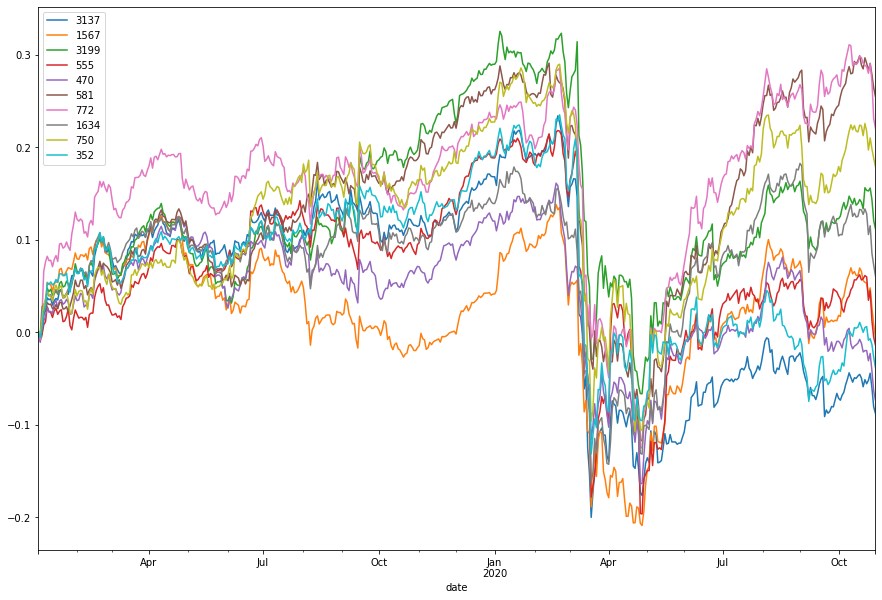

In [9]:
returns_to_equity(df_pfs_returns.sample(n=10, axis=1)).plot(figsize=(15, 10), legend=True)

# Analyze results with PSR

First we are going to look for the portfolios with the highests SRs.

In [11]:
ann_best_srs = ann_estimated_sharpe_ratio(df_pfs_returns).sort_values(ascending=False)
ann_best_srs

954     1.916048
3672    1.764027
2074    1.685596
2880    1.638898
132     1.617286
          ...   
2943   -0.795281
1806   -0.825106
2385   -0.911537
2133   -0.942349
453    -0.942637
Length: 5000, dtype: float64

Ohh the portfolio 954 have a Sharpe Ratio of almonst 2.00!

But now we know that we do not have to look for the portfolios with the highest SR only. We must look for the portfolios with a high Probabilistic Sharpe Ratio,
We need to chechk if there is a high probability in that our SR estimation will be true in the future.

Lets calculate the PSR of all the portfolios:

In [14]:
probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False)

954     0.996373
2074    0.990684
2880    0.990134
3672    0.988739
132     0.987605
          ...   
2943    0.134335
1806    0.121073
2385    0.097034
453     0.090094
2133    0.082750
Length: 5000, dtype: float64

NICE!
The portfolio 954 have a very high PSR. Its PSR indicates that there is a probability of 99.64% that the SR of that strategy will be greater than 0 (SR benchmark) in the future. It looks great! 

# Analyze results with DSR (avoid multiple testing problem)

But wait, in the last post we have seen that de PSR only works under the assumption of a single trial. And we have backtested 5000 trials!! So we need to calculate de Deflated Sharpe Ratio to correct the inflation of the SR due to our multiple testing.

Lets check the DSR for the portfolio 954!

In [16]:
best_psr_pf_name = probabilistic_sharpe_ratio(returns=df_pfs_returns, sr_benchmark=0).sort_values(ascending=False).index[0]
best_psr_pf_returns = df_pfs_returns[best_psr_pf_name]

In [17]:
best_psr_pf_name

954

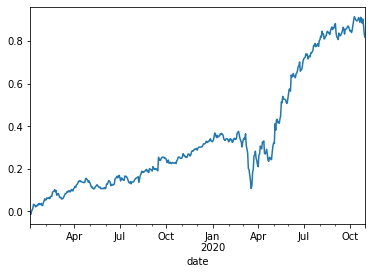

In [18]:
returns_to_equity(best_psr_pf_returns).plot()

Mmmm the euqity curve looks so nice, but what about the DSR?

In [19]:
dsr = deflated_sharpe_ratio(trials_returns=df_pfs_returns, returns_selected=best_psr_pf_returns)
dsr

0.8235745817687179

**Oooppps, the Deflated Sharpe Ratio is saying us that statistically we only have 82% chances that our strategy have an edge, and can give us positive returns in the future.**

**Statistically we do not have a sufficient (95%) level of confidence that our strategy will win money in the future. Rather, it is quite likely that the good results we have seen in the backtest are the result of overffiting. We have been fooled by randomness!**

### Internal calculations for de DSR

In [21]:
independent_trials = num_independent_trials(trials_returns=df_pfs_returns)
independent_trials

1240

In [22]:
exp_max_sr = expected_maximum_sr(trials_returns=df_pfs_returns, independent_trials=independent_trials)
exp_max_sr

0.07756158920421583

In [23]:
exp_max_sr_annualized = ann_estimated_sharpe_ratio(sr=exp_max_sr)
exp_max_sr_annualized

1.2530458217038996

In [24]:
deflated_sharpe_ratio(returns_selected=best_psr_pf_returns, expected_max_sr=exp_max_sr)

0.8235745817687179